# Binance Profit Calculator 
`Written by @cryptoDey94 (telegram)` <br/>
Donations Appreciated :)<br/>
BTC Address: 1MLadoaCujyjXZUfbKR4greXiR84SaH4T8 <br/>

## Designed for use with [Gunbot](https://github.com/GuntharDeNiro/BTCT/wiki), but will work for any binance trading history. 


# Usage Instructions


## Download trading history from Binance

Log on to Binance and navigate to `Orders` -> `Trade History`. On the top right should be an option `Export complete trade history`. Click on that, chose a time period, and download the excel file. Make sure this .ipynb fle is in the same folder as `TradeHistory.xlsx`. (If filename is different than that, change the filename in the below cell). No personal information is contained in the trading history excel file.

In [1]:
filename = 'TradeHistory.xlsx'

## Run this file

To run this file, I reccomend using Anaconda Navigator. To download, click the link below. Then open Anaconda Navigator, and click `Launch` under `Jupyter notebook`. Your browser will open with a screen to select which .ipynb file to open. Download and open this one, but before running, finish reading instructions. 
https://www.anaconda.com/download/

## Notes on the program

The program calculates profits based on round-trip trades in the given time period. That is, for each coin pair, any sells that come before any buys and any buys that come after any sells will not be calculated. Thus, only full trades (trades that contain a buy and a sell) will be calcuated for profit. This is the most accurate way to determine how much profit you accumulated in the given time period.

The program calculates fees based on BNB. If you do not use BNB for fees, A. You should since its half the cost and B. you need to set the variable `use_fees` below to `False`. Note, this will calculate total revenue instead of total profit. 

In [2]:
use_fees = True

In [3]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

# initialize variables we will need

i = 0
totalProfit = 0.0
rawGroupDfs = {}
brokenDf = pd.DataFrame(columns=['Name', 'Total Bought', 'Total Sold', 'Profit', 'Fee'])
resultDf = pd.DataFrame(columns=['Name', 'Total Bought', 'Total Sold', 'Profit', 'Fee'])
df = pd.read_excel(filename)
print('Successfully Imported Excel File. Printing first 10 rows...')
df.head(10)

Successfully Imported Excel File. Printing first 10 rows...


,Date,Market,Type,Price,Amount,Total,Fee,Fee Coin
0,2018-02-10 19:54:28,ZECBTC,BUY,0.055998,0.052,0.002912,0.000402,BNB
1,2018-02-10 19:54:28,ZECBTC,BUY,0.055999,0.582,0.032591,0.004505,BNB
2,2018-02-10 19:53:06,OMGBTC,BUY,0.001412,0.550,0.000777,0.000107,BNB
3,2018-02-10 19:25:07,ETCBTC,BUY,0.002789,12.740,0.035532,0.004914,BNB
4,2018-02-10 17:53:10,XMRBTC,SELL,0.029272,1.224,0.035829,0.004926,BNB
5,2018-02-10 17:10:27,XMRBTC,BUY,0.029021,1.224,0.035522,0.004906,BNB
6,2018-02-10 15:43:04,SUBBTC,BUY,0.000086,412.000,0.035510,0.004775,BNB
7,2018-02-10 15:41:05,LTCBTC,BUY,0.018400,1.930,0.035512,0.004776,BNB
8,2018-02-10 15:36:28,POWRBTC,BUY,0.000089,398.000,0.035498,0.004766,BNB
9,2018-02-10 15:25:30,CNDBTC,BUY,0.000022,1495.000,0.032217,0.004356,BNB


The below code sanitizes the data and calculates profits based on the complete trades rules we have set above in `O(n)` time. 

In [4]:
xls = df.groupby(df['Market'])

#loop start - long cell bc all work being calculated in one go AKA O(n)
for name, group in xls:
    
    group = group.sort_values(by=['Date'], ascending=True)
    rawGroupDfs[name] = copy.deepcopy(group)
    
    # Create group dataframes for profit calculations
    group_df = pd.DataFrame(columns=['Total Bought', 'Total Sold', 'Profit', 'Fee'])
    

    ## Remove sells from top
    group = group.reset_index()
    for index, row in group.iterrows():
        if row['Type'] == 'SELL':
            group.drop(index, inplace=True)
        else:
            break

    ## Remove buys from bottom
    while group['Type'].count() > 0 and group.iloc[-1]['Type'] == 'BUY':
        group = group[:-1]


    #check for groups that only sold or bought, dont count them
    if len(group['Type'].unique()) == 1:
        continue
        
    
    ## Calculate profits, if the total amount of bought and sold coins match up -- (per group)
    
    totalCostForCurrentGroup = 0.0
    totalRevenueForCurrentGroup = 0.0
    totalFeeForCurrentGroup = 0.0
    totalAmountForBuys = 0.0
    totalAmountForSells = 0.0
    totalProfitForCurrentGroup = 0.0
    for index, row in group.iterrows():
        if row['Type'] == 'BUY':
            totalAmountForBuys = totalAmountForBuys + float(row['Amount'])
            totalCostForCurrentGroup = totalCostForCurrentGroup + float(row['Total'])
        if row['Type'] == 'SELL':
            totalAmountForSells = totalAmountForSells + float(row['Amount'])
            totalRevenueForCurrentGroup = totalRevenueForCurrentGroup + float(row['Total'])
        totalFeeForCurrentGroup = totalFeeForCurrentGroup + float(row['Fee'])
        totalProfitForCurrentGroup = totalRevenueForCurrentGroup - totalCostForCurrentGroup

    # sometimes there is a slight difference in the amount bought / sold 
    # (maybe limit orders didnt get fully filled in time or owned coins from prev trades)
    # We will recalculate profits to be conservative to the lower amount
    
    newTotalAmountForSells = 0.0
    newTotalAmountForBuys = 0.0
    totalProfitForCurrentGroup = totalRevenueForCurrentGroup - totalCostForCurrentGroup
    group_df = pd.DataFrame()
    
    if totalAmountForSells > totalAmountForBuys:
        group_df = group_df.set_value(i, 'Only counting', totalAmountForSells if totalAmountForBuys > totalAmountForSells else totalAmountForBuys)
        totalProfitForCurrentGroup = totalProfitForCurrentGroup * (totalAmountForBuys / totalAmountForSells)
        print('Fixing relative profit for group ' + name)
        print('\n')
        
    if totalAmountForSells < totalAmountForBuys:
        group_df = group_df.set_value(i, 'Only counting', totalAmountForSells if totalAmountForBuys > totalAmountForSells else totalAmountForBuys)        
        totalProfitForCurrentGroup = totalProfitForCurrentGroup * (totalAmountForSells / totalAmountForBuys)
        print('Fixing relative profit for group ' + name)
        print('\n')

    group_df = group_df.set_value(i, 'Total Bought', totalAmountForBuys)
    group_df = group_df.set_value(i, 'Total Sold', totalAmountForSells)
    group_df = group_df.set_value(i, 'Profit', totalProfitForCurrentGroup)
    group_df = group_df.set_value(i, 'Fee', totalFeeForCurrentGroup)
    group_df = group_df.set_value(i, 'Name', name)
    if totalProfitForCurrentGroup > 0 :
        resultDf = resultDf.append(group_df)
    else: 
        brokenDf = brokenDf.append(group_df)
        if totalProfitForCurrentGroup == 0.0:
            print('Group ' + name + ' had no round trip trades in this time period')
            print('\n')
        else:
            print('Problems calculating group ' + name + 
                  '. Total profit not added to final result is: ' + str(totalProfitForCurrentGroup))
            print('\n')

    i = i + 1
    
#loop over

/Users/dimitrideychakiwsky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dimitrideychakiwsky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dimitrideychakiwsky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dimitrideychakiwsky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dimitrideychakiwsky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and wi

Fixing relative profit for group ADABTC


Group BTGBTC had no round trip trades in this time period


Group BTSBTC had no round trip trades in this time period


Fixing relative profit for group ETHBTC


Group LUNBTC had no round trip trades in this time period


Fixing relative profit for group SNTBTC


Group STRATBTC had no round trip trades in this time period


Fixing relative profit for group XVGBTC


Fixing relative profit for group ZECBTC




In [5]:
print('Successful calculation of below groups:')
resultDf.fillna('-')

Successful calculation of below groups:


,Fee,Name,Only counting,Profit,Total Bought,Total Sold
0,0.196967,ADABTC,4131,0.023622,4131.000,4555.000
1,0.402617,BCDBTC,-,0.007096,78.398,78.398
4,0.424939,CNDBTC,-,0.006785,20565.000,20565.000
5,0.027002,ETCBTC,-,0.001261,21.540,21.540
6,0.034367,ETHBTC,0.303,0.000518,0.303,0.303
7,0.031223,HSRBTC,-,0.001147,51.770,51.770
8,0.065395,IOTABTC,-,0.001510,358.000,358.000
9,0.090358,LTCBTC,-,0.001091,6.190,6.190
11,0.035530,MCOBTC,-,0.000594,33.250,33.250
12,0.194931,OMGBTC,-,0.002490,177.590,177.590


In [6]:
profitDf = pd.DataFrame(columns=['Total Profit BTC', 'Total Fees BNB'])
profitDf['Total Profit BTC'] = [resultDf['Profit'].sum()]
profitDf['Total Fees BNB'] = [resultDf['Fee'].sum()]
profitDf.index = ['Total']

In [7]:
print('These were not added to final result. If all 0, then no round trip trades for these groups exist in the given time period. If running many pairs, this is expected.')
brokenDf

These were not added to final result. If all 0, then no round trip trades for these groups exist in the given time period. If running many pairs, this is expected.


,Fee,Name,Profit,Total Bought,Total Sold
2,0.0,BTGBTC,0.0,0.0,0.0
3,0.0,BTSBTC,0.0,0.0,0.0
10,0.0,LUNBTC,0.0,0.0,0.0
16,0.0,STRATBTC,0.0,0.0,0.0


In [8]:
#USD Profits
usProfitDf = pd.DataFrame(index=[8000, 10000, 12000, 15000, 20000, 25000, 50000, 100000], 
                          columns=['USD Profit with given cost of BTC'])
usProfitDf['USD Profit with given cost of BTC'] = usProfitDf.index * resultDf['Profit'].sum()
usProfitDf.index.name = 'Price BTC'


In [9]:
# Get profit in USD from real time BTC price from coinmarketcap

import requests

response = requests.get('https://api.coinmarketcap.com/v1/ticker/bitcoin/') 
response2 = requests.get('https://api.coinmarketcap.com/v1/ticker/binance-coin/') 
realTimeProfitDf = pd.DataFrame(index=['Total'])
if use_fees:
    realTimeProfitDf['USD Profit At Current BTC Price'] = float(response.json()[0]['price_usd']) * resultDf['Profit'].sum() - float(response2.json()[0]['price_usd']) * resultDf['Fee'].sum()
else:
    realTimeProfitDf['USD Profit At Current BTC Price'] = float(response.json()[0]['price_usd']) * resultDf['Profit'].sum()

In [10]:
profitDf

,Total Profit BTC,Total Fees BNB
Total,0.108422,3.185559


In [11]:
pd.options.display.float_format = '${:,.2f}'.format
print(usProfitDf.to_string(index=True))

           USD Profit with given cost of BTC
Price BTC                                   
8000                                 $867.38
10000                              $1,084.22
12000                              $1,301.07
15000                              $1,626.34
20000                              $2,168.45
25000                              $2,710.56
50000                              $5,421.12
100000                            $10,842.24


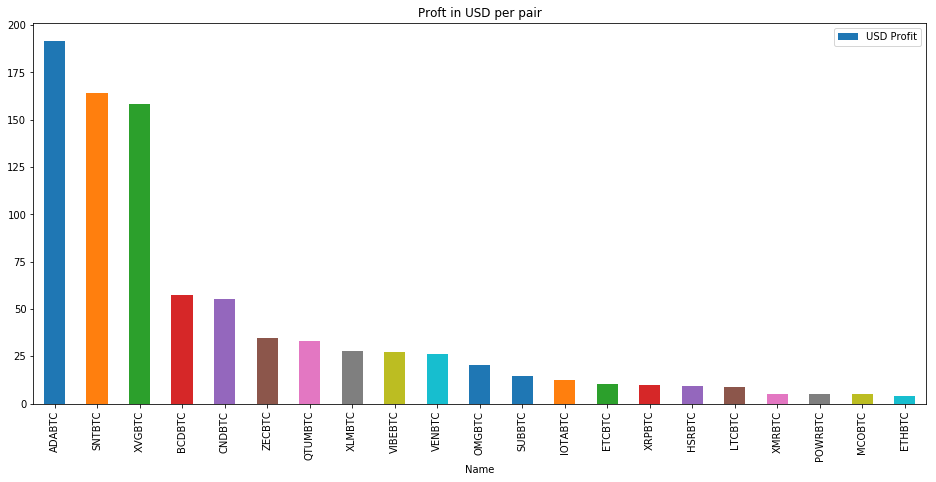

Name  USD Profit
 ADABTC     $191.53
 SNTBTC     $164.09
 XVGBTC     $158.28
 BCDBTC      $57.54
 CNDBTC      $55.01
 ZECBTC      $34.38
QTUMBTC      $33.25
 XLMBTC      $27.64
VIBEBTC      $27.01
 VENBTC      $25.99
 OMGBTC      $20.19
 SUBBTC      $14.56
IOTABTC      $12.24
 ETCBTC      $10.23
 XRPBTC       $9.92
 HSRBTC       $9.30
 LTCBTC       $8.84
 XMRBTC       $5.09
POWRBTC       $4.99
 MCOBTC       $4.82
 ETHBTC       $4.20


In [12]:
resultDf['USD Profit'] = (float(response.json()[0]['price_usd']) * resultDf['Profit'])
resultDf = resultDf.sort_values(by='USD Profit', ascending=False)
ax = resultDf.plot(x='Name', y='USD Profit', kind='bar', figsize=(16,7), title='Proft in USD per pair')
plt.show()
finalDf = pd.DataFrame(resultDf[['Name','USD Profit']], index=None)

print(finalDf.to_string(index=False))

In [13]:
import datetime as datetime
print ('Current Bitcoin Price as of ' + datetime.datetime.now().strftime('%I:%M %p on %B %d, %Y') + ' is: ' + "${:,.2f}".format(float(response.json()[0]['price_usd'])))

Current Bitcoin Price as of 02:33 AM on February 11, 2018 is: $8,108.10


In [14]:
end = pd.to_datetime(df['Date'].iloc[0]).strftime('%A, %B %d')
start = pd.to_datetime(df['Date'].iloc[-1]).strftime('%A, %B %d')
feeCost = float(response2.json()[0]['price_usd']) * float(resultDf['Fee'].sum())
label = str('Profit from ' + str(start) + ' to ' + str(end) + ' in USD')
realTimeProfitDf.columns=[label]
print('\n')
print(str('Fee\'s from BNB ' + str(start) + ' to ' + str(end) + ' currently costs ' + "${:,.2f}".format(feeCost) + ' in USD.'))
print('\n')
realTimeProfitDf



Fee's from BNB Thursday, February 01 to Saturday, February 10 currently costs $27.04 in USD.




,"Profit from Thursday, February 01 to Saturday, February 10 in USD"
Total,$852.06
